In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./src') 
from xgboost_utils import train_xgb
from xgboost_predictor import generate_sparse_pgv

## Step 1: Train XGBoost Models per Receiver and Generate Sparse Maps

1- We train one XGBoost model per receiver  


Training R²: 0.9302
Test R²: 0.8886


Text(0, 0.5, 'Predicted log(PGV) (mm/s)')

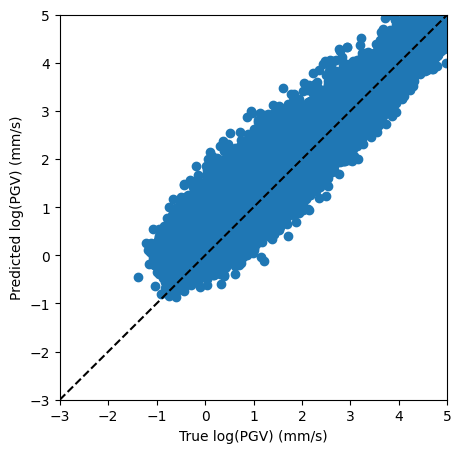

In [2]:
# load input and output data for receiver
receiver_idx         = 139
receiver_database    = np.load(f'/media/wolf6819/Elements/reciprocal_db/receiver_{receiver_idx}_database.npz')
inputs  = receiver_database['inputs']   # source coords and mechanism ([distance, azimuth, depth, strike, dip, rake, radiation, takeoff] )
outputs = receiver_database['outputs']  # pgv along two components (East-West, North-South) in mm/s

# train xgboost model 
pgv_true, pgv_pred = train_xgb(inputs, np.log(outputs[:,0]))  
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(pgv_true, pgv_pred)
ax.set_xlim([-3,5])
ax.set_ylim([-3,5])
ax.plot([-3, 5], [-3, 5], 'k--')
ax.set_xlabel('True log(PGV) (mm/s)')
ax.set_ylabel('Predicted log(PGV) (mm/s)')

2- We repeat the process above for all the receivers. The trained models for each receiver 
and for each of the components are stored in the `models/` directory. 

3 - We use the trained XGBoost models to generate sparse PGV maps for the forward simulations (used as input for Step 2) 

In [ ]:
# generate a sparse PGV map for input source coordinates and focal mechanism
# we show an example for the database with 50 source locations, and 50 mechanims per locations refered to as 50_50

data_tag   = '50_50'  
models_dir = '/media/wolf6819/Elements/models/'
spacing_km = 4 
station_coords_path = 'data/station_coords_sparse.npz' 
output_path         = 'data/step1_preds'

sparse_maps = generate_sparse_pgv(station_coords_path, models_dir, output_path, data_tag, spacing_km)

In [ ]:
# an example of a sparse PGV map  
station_coords_file = 'data/station_coords_sparse.npz'  
station_coords = np.load(station_coords_file)['station_coords']
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(station_coords[:,0]/1e3, station_coords[:,1]/1e3, c = sparse_maps[100,:,:,0], s=100, cmap='plasma')
# make it nicer
ax.set_xlabel('East Distance (km)') 
ax.set_ylabel('North Distance (km)')    

## Step 2: Train the Encoder-MLP on Sparse Maps

We use the predicted sparse maps to train an EncoderMLP network 


In [5]:
downsample_factor = 4
data_tag          = "50_50_x4"


# train encoder MLP predictor
!python src/encoderMLP_predictor.py \
  --mode train \
  --data_tag {data_tag} \
  --downsample_factor {downsample_factor} \
  --num_epochs 1 



Run ID: 20250617_084729_9a179d | Seed: 2094760277
Number of patches: 32000
Training Epochs: 100%|███████████████████████████| 1/1 [01:48<00:00, 108.07s/it]
Configuration saved to ./results/20250617_084729_9a179d/config.yaml.


Next, we test the trained network on an independent set of test events, the results are stored in the relevant dir in the `./results` folder

In [6]:
data_tag = "50_50_x4"
downsample_factor = 4

# Use an f-string to format the shell command
!python src/encoderMLP_predictor.py \
  --mode test \
  --data_tag {data_tag} \
  --results_dir  ./results/20250617_084729_9a179d \
  --downsample_factor {downsample_factor}



Testing only | Using results from: ./results/20250617_084729_9a179d | Seed: 2094921063
(500,)
Reconstructing patches For Test Maps: 100%|█| 12500/12500 [00:58<00:00, 213.93it
Test SSIM: 0.7135


We show an example of the true (simulated) vs predicted PGV maps 

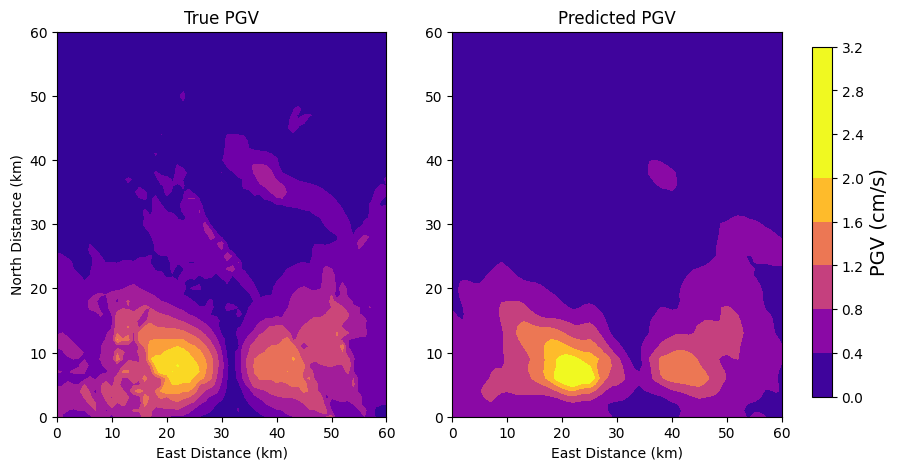

In [8]:
preds = np.load('./results/20250617_084729_9a179d/test_preds.npy')
gts   = np.load('./results/20250617_084729_9a179d/test_gts.npy')  

fig, ax = plt.subplots(1, 2, figsize=(10, 5))  
# choose a random idx between 0 and the number of samples in preds  
idx  = np.random.randint(0, preds.shape[0]) 
pred = preds[idx,:,:,0]/10  # predicted PGV    
gt   = gts[idx,:,:,0]/10    # true PGV
norm = plt.Normalize(vmin=0, vmax=np.max(gt)) 
   
cf0 = ax[0].contourf(gt, cmap='plasma', norm=norm)
cf1 = ax[1].contourf(pred, cmap='plasma', norm=norm)

ax[0].set_title('True PGV')    
ax[1].set_title('Predicted PGV')
ax[0].set_xlabel('East Distance (km)')  
ax[0].set_ylabel('North Distance (km)') 
ax[1].set_xlabel('East Distance (km)')  

fig.subplots_adjust(right=0.85)  
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7]) 
fig.colorbar(cf1, cax=cbar_ax).set_label("PGV (cm/s)", fontsize=14)

plt.show()